In [19]:
import cv2
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam

Link video nomor 2: https://binusianorg-my.sharepoint.com/personal/johensen_charles_binus_ac_id/_layouts/15/guestaccess.aspx?share=Eandy7Bxg3dLmmBA7VJmdjUBy0dW8g2Nw9wU3jxo7w4Y5A&nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJPbmVEcml2ZUZvckJ1c2luZXNzIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXciLCJyZWZlcnJhbFZpZXciOiJNeUZpbGVzTGlua0NvcHkifX0&e=0fNS02

## EDA

In [2]:
image_paths = sorted(glob("/kaggle/input/uas-deeplearning/A_23/*.jpg"))

In [3]:
# jumlah gambar
num_images = len(image_paths)
num_images

1074

In [4]:
image_data = []

for path in image_paths:
    try:
        with Image.open(path) as img:
            width, height = img.size
            mode = img.mode
            is_rgb = 1 if mode == "RGB" else 0
            image_data.append((width, height, is_rgb))
    except Exception as e:
        image_data.append((None, None, None))  # mark problematic image


df_images = pd.DataFrame(image_data, columns=["width", "height", "is_rgb"])

df_images.describe()

,width,height,is_rgb
count,1074.0,1074.0,1074.0
mean,600.0,600.0,1.0
std,0.0,0.0,0.0
min,600.0,600.0,1.0
25%,600.0,600.0,1.0
50%,600.0,600.0,1.0
75%,600.0,600.0,1.0
max,600.0,600.0,1.0


Terlihat bahwa dari seluruh data, semuanya memiliki dimensi 600x600 dan color channel RGB. Sehingga tidak ada data anomali yang perlu mendapat perlakuan khusus.

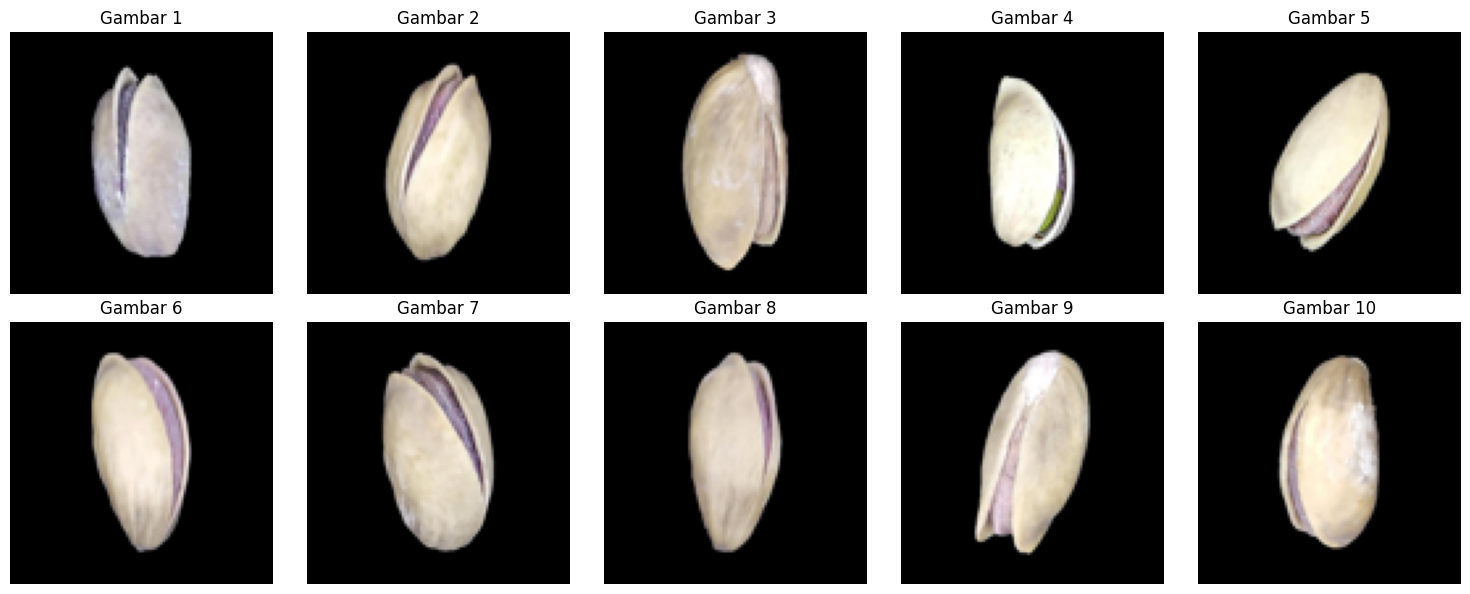

In [5]:
# Tampilkan beberapa gambar sebagai sampel
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    img = Image.open(image_paths[i]).resize((100, 100))
    ax.imshow(img)
    ax.set_title(f"Gambar {i+1}")
    ax.axis("off")
plt.tight_layout()
plt.show()

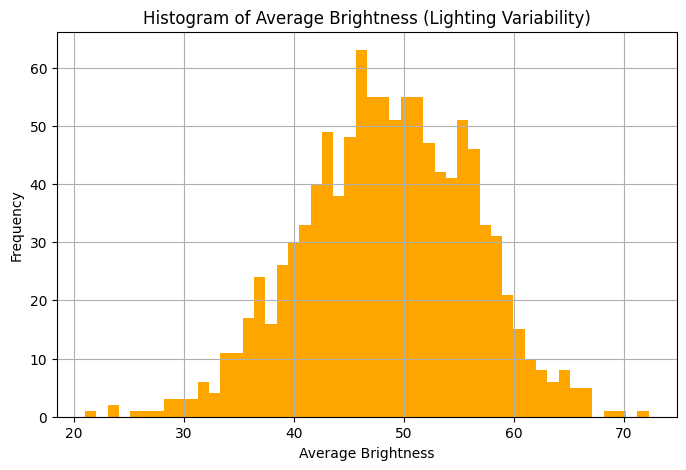

72.26613611111111 21.051577777777776 48.560377110490386 7.652639962575441


In [6]:
# Distribusi cahaya
def average_brightness(image):
    img_array = np.array(image.convert('L'))  # Convert to grayscale
    return np.mean(img_array)

brightness_values = []

for path in image_paths:
    try:
        with Image.open(path) as img:
            brightness_values.append(average_brightness(img))
    except Exception as e:
        continue

# Plot histogram brightness
plt.figure(figsize=(8, 5))
plt.hist(brightness_values, bins=50, color='orange')
plt.title('Histogram of Average Brightness (Lighting Variability)')
plt.xlabel('Average Brightness')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(max(brightness_values), min(brightness_values), np.mean(brightness_values), np.std(brightness_values))

Terlihat bahwa gambar memiliki rata rata brightness yang terpusat di sekitar 40-60. Nilai ini bisa dikatakan agak gelap, tapi tidak terlalu gelap. Hal ini cukup baik untuk data denoising karena memang menghindari gambar yang overexposed, tapi mungkin perlu diperhatikan ada sedikit outlier yang memiliki avg brightness agak rendah (21.05)

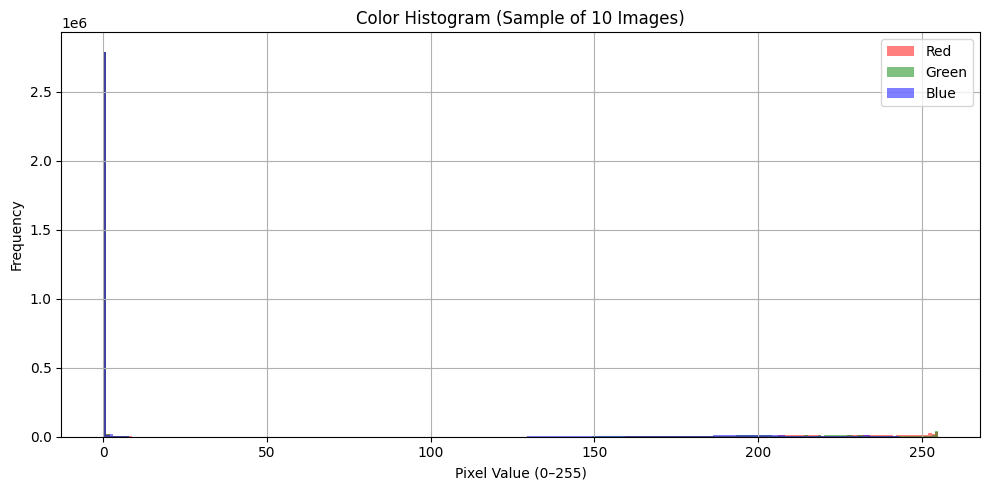

In [7]:
# distribusi warna
def compute_color_histogram(folder, max_images=10):
    r_vals, g_vals, b_vals = [], [], []

    count = 0
    for img_name in os.listdir(folder):
        if img_name.lower().endswith(('jpg', 'jpeg', 'png')):
            img_path = os.path.join(folder, img_name)
            try:
                with Image.open(img_path).convert('RGB') as img:
                    r, g, b = img.split()
                    r_vals.extend(np.array(r).flatten())
                    g_vals.extend(np.array(g).flatten())
                    b_vals.extend(np.array(b).flatten())
                    count += 1
                    if count >= max_images:
                        break
            except Exception as e:
                continue

    return r_vals, g_vals, b_vals

# Plot histogram warna (RGB) dari 10 sample
r, g, b = compute_color_histogram("/kaggle/input/uas-deeplearning/A_23", max_images=10)

plt.figure(figsize=(10, 5))
plt.hist(r, bins=256, alpha=0.5, color='r', label='Red')
plt.hist(g, bins=256, alpha=0.5, color='g', label='Green')
plt.hist(b, bins=256, alpha=0.5, color='b', label='Blue')
plt.title('Color Histogram (Sample of 10 Images)')
plt.xlabel('Pixel Value (0–255)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Terlihat bahwa dari distribusi warna, sebagian besar ada di nilai 0, karena memang background dari objek berwarna hitam, dan porsi antara background dengan object hampir setara, sehingga wajar jika nilai 0 pada grafik cukup tinggi. Hal ini sebenarnya dapat diatasi dengan cropping (mengurangi porsi background) supaya lebih terfokus pada objek, tapi ada resiko objek terpotong dan manfaatnya untuk denoising tidak se-signifikan itu sehingga sebaiknya tidak perlu diapa apakan.

## Preprocess

In [8]:
# Preprocessing dan noise
def preprocess_and_add_noise(image_paths, image_size=(100, 100), noise_mean=0.0, noise_std=0.1):
    clean_images = []
    noisy_images = []

    for path in image_paths:
        try:
            with Image.open(path).convert('RGB') as img:
                img_resized = img.resize(image_size)
                img_array = np.asarray(img_resized) / 255.0  # Normalisasi ke [0, 1]

                noise = np.random.normal(noise_mean, noise_std, img_array.shape)
                noisy_img = np.clip(img_array + noise, 0., 1.)

                clean_images.append(img_array)
                noisy_images.append(noisy_img)
        except:
            continue

    clean_images = np.array(clean_images, dtype=np.float32)
    noisy_images = np.array(noisy_images, dtype=np.float32)
    return noisy_images, clean_images

# Lanjutkan preprocessing
noisy_imgs, clean_imgs = preprocess_and_add_noise(image_paths)

In [9]:
# Split data: 80/10/10
X_train, X_temp, y_train, y_temp = train_test_split(noisy_imgs, clean_imgs, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

variabel x menyimpan data yang sudah diberi noise sedangkan variabel y menyimpan data bersih sebagai target  
perbandingan splitnya 80% untuk training, 10% untuk validasi saat training dan 10% untuk testing

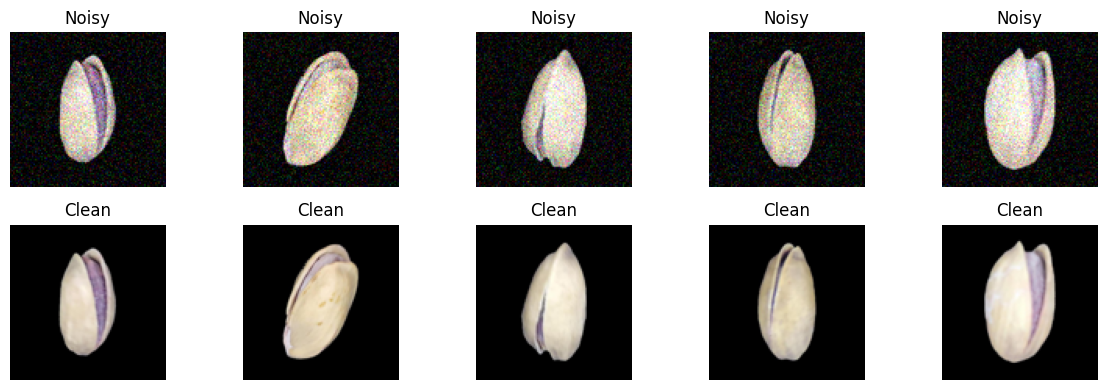

In [11]:
def show_denoising_samples(noisy_images, clean_images, n=5):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        # Noisy image
        plt.subplot(2, n, i + 1)
        plt.imshow(noisy_images[i])
        plt.title("Noisy")
        plt.axis("off")

        # Clean image
        plt.subplot(2, n, n + i + 1)
        plt.imshow(clean_images[i])
        plt.title("Clean")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Tampilkan 5 sampel dari training data
show_denoising_samples(X_train, y_train)

## Base Model

In [20]:
input_img = Input(shape=(100, 100, 3))

# Encoder
x_base = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)   # -> (100, 100, 32)
x_base = MaxPooling2D((2, 2), padding='same')(x_base)                            # -> (50, 50, 32)
x_base = Conv2D(64, (3, 3), activation='relu', padding='same')(x_base)           # -> (50, 50, 64)
x_base = MaxPooling2D((2, 2), padding='same')(x_base)                            # -> (25, 25, 64)

# Decoder
x_base = Conv2D(64, (3, 3), activation='relu', padding='same')(x_base)           # -> (25, 25, 64)
x_base = UpSampling2D((2, 2))(x_base)                                            # -> (50, 50, 64)
x_base = Conv2D(32, (3, 3), activation='relu', padding='same')(x_base)           # -> (50, 50, 32)
x_base = UpSampling2D((2, 2))(x_base)                                            # -> (100, 100, 32)
decoded_base = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x_base)   # -> (100, 100, 3)

In [12]:
autoencoder = Model(input_img, decoded_base)
autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 25, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 50, 50, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 100, 100, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

Karena paddingnya same, maka setelah konvolusi dimensi gambar tetap sama, sehingga downsamplingnya terjadi ketika maxpooling dimana dimensi berkurang jadi setengahnya. Kemudian, setelah mencapai bottleneck (25x25), data diupsampling hingga mencapai dimensi sama dengan input (100x100)  

100x100 -> 50x50 -> 25x25 -> 50x50 -> 100x100  

Sempat terkecoh dengan jumlah filter pada Convolutional, karena pada dense autoencoder, jumlah neuron = dimensi output. Sedangkan di Convolutional jumlah kernel ≠ dimensi output, tapi bergantung pada ukuran filter, stride dan padding.

In [21]:
# training
history = autoencoder.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val, y_val)
)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 9.4956e-04 - val_loss: 8.6166e-04
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.3345e-04 - val_loss: 8.8824e-04
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9.0204e-04 - val_loss: 8.9541e-04
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.9171e-04 - val_loss: 8.4482e-04
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0010 - val_loss: 8.6794e-04
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.5747e-04 - val_loss: 8.1160e-04
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.0515e-04 - val_loss: 7.7480e-04
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.6417e-04 - val_loss: 7.7192e-04
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.8368e-04 - val_loss: 7.5438e-04
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.5893e-04 - val_loss: 7.4551e-04
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.5941e-04 - 

## Model Modifikasi

In [22]:
# Encoder
x_modif = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)            # (100, 100, 32)
x_modif = MaxPooling2D((2, 2), padding='same')(x_modif)                               # (50, 50, 32)
x_modif = Conv2D(64, (3, 3), activation='relu', padding='same')(x_modif)              # (50, 50, 64)
x_modif = MaxPooling2D((2, 2), padding='same')(x_modif)                               # (25, 25, 64)
x_modif = Conv2D(128, (3, 3), activation='relu', padding='same')(x_modif)             # (25, 25, 128) ← tambahan layer

# Decoder pakai Conv2DTranspose
x_modif = Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x_modif)   # (50, 50, 64)
x_modif = Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x_modif)   # (100, 100, 32)
decoded_modif = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x_modif)                     # (100, 100, 3)

- Conv2D tambahan: supaya model bisa lihat pola lebih dalam dan menangkap noise yang lebih kompleks.
- Conv2DTranspose: supaya upsampling bisa dipelajari, bukan sekadar interpolasi dari hasil upsampling, ekspektasinya supaya hasil rekonstruksi lebih tajam. Dari artikel yang saya baca, Conv2D itu digunakan seperti untuk deteksi fitur dan membuat dimensi output lebih kecil. Sedangkan Conv2DTranspose untuk membuat fitur dan membuat dimensi output lebih besar.

In [23]:
autoencoder_mod = Model(input_img, decoded_modif)
autoencoder_mod.compile(optimizer=Adam(), loss='mean_squared_error')
autoencoder_mod.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 50, 50, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 100, 100, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 100, 100, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 186,371 (728.01 KB)

 Trainable params: 186,371 (728.01 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Train model modifikasi
history_mod = autoencoder_mod.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val, y_val)
)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.1663 - val_loss: 0.0122
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0087 - val_loss: 0.0031
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0

## Evaluasi

In [25]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse_list, mae_list, ssim_list = [], [], []

    for i in range(len(y_test)):
        gt = y_test[i]
        pred = y_pred[i]
        mse_list.append(mean_squared_error(gt.flatten(), pred.flatten()))
        mae_list.append(mean_absolute_error(gt.flatten(), pred.flatten()))
        ssim_list.append(ssim(gt, pred, channel_axis=2, data_range=1.0))

    metrics = {
        "MSE": np.mean(mse_list),
        "MAE": np.mean(mae_list),
        "SSIM": np.mean(ssim_list)
    }

    return metrics, y_pred

# Evaluasi model baseline dan modifikasi
baseline_metrics, y_pred_base = evaluate_model(autoencoder, X_test, y_test)
mod_metrics, y_pred_mod = evaluate_model(autoencoder_mod, X_test, y_test)

print("Evaluasi Baseline Autoencoder:")
print(f"🔹 MSE:  {baseline_metrics['MSE']:.6f}")
print(f"🔹 MAE:  {baseline_metrics['MAE']:.6f}")
print(f"🔹 SSIM: {baseline_metrics['SSIM']:.4f}")

print("\nEvaluasi Autoencoder Modifikasi:")
print(f"🔹 MSE:  {mod_metrics['MSE']:.6f}")
print(f"🔹 MAE:  {mod_metrics['MAE']:.6f}")
print(f"🔹 SSIM: {mod_metrics['SSIM']:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
Evaluasi Baseline Autoencoder:
🔹 MSE:  0.000637
🔹 MAE:  0.008805
🔹 SSIM: 0.9562

Evaluasi Autoencoder Modifikasi:
🔹 MSE:  0.000983
🔹 MAE:  0.011237
🔹 SSIM: 0.9471


Dari nilai MSE dan MAE, terlihat bahwa terjadi penurunan antara baseline dan modifikasi, artinya model modifikasi mampu menghasilkan gambar yang jika dihitung secara numerik dengan gambar aktual, perbedaan valuenya lebih kecil atau errornya lebih kecil. Namun, dari nilai numerik ini sebenarnya belum jelas gambaran riilnya seperti apa  

Maka kita evaluasi menggunakan SSIM, dimana pada baseline model, SSIM sebesar 0.9421 yang artinya model berhasil membuat gambar noise menjadi sebuah gambar dengan similarity index 94.2% dengan gambar aktual. Kemudian, pada model modifikasi, nilainya naik sedikit mencapai 0.9494 yang artinya hasil dari model modifikasi memiliki similarity index 94.9% dengan gambar aktual. Dapat disimpulkan bahwa model modifikasi berhasil melakukan peningkatan kualitas rekonstruksi gambar  

Sehingga untuk model akhir yang digunakan sebagai model denoiser, model modifikasi ini lebih layak dibandingkan dengan baseline model dan secara performa sudah cukup bagus karena SSIM atau kesamaan antara hasil rekonstruksi dengan aktual mencapai 94.9%.

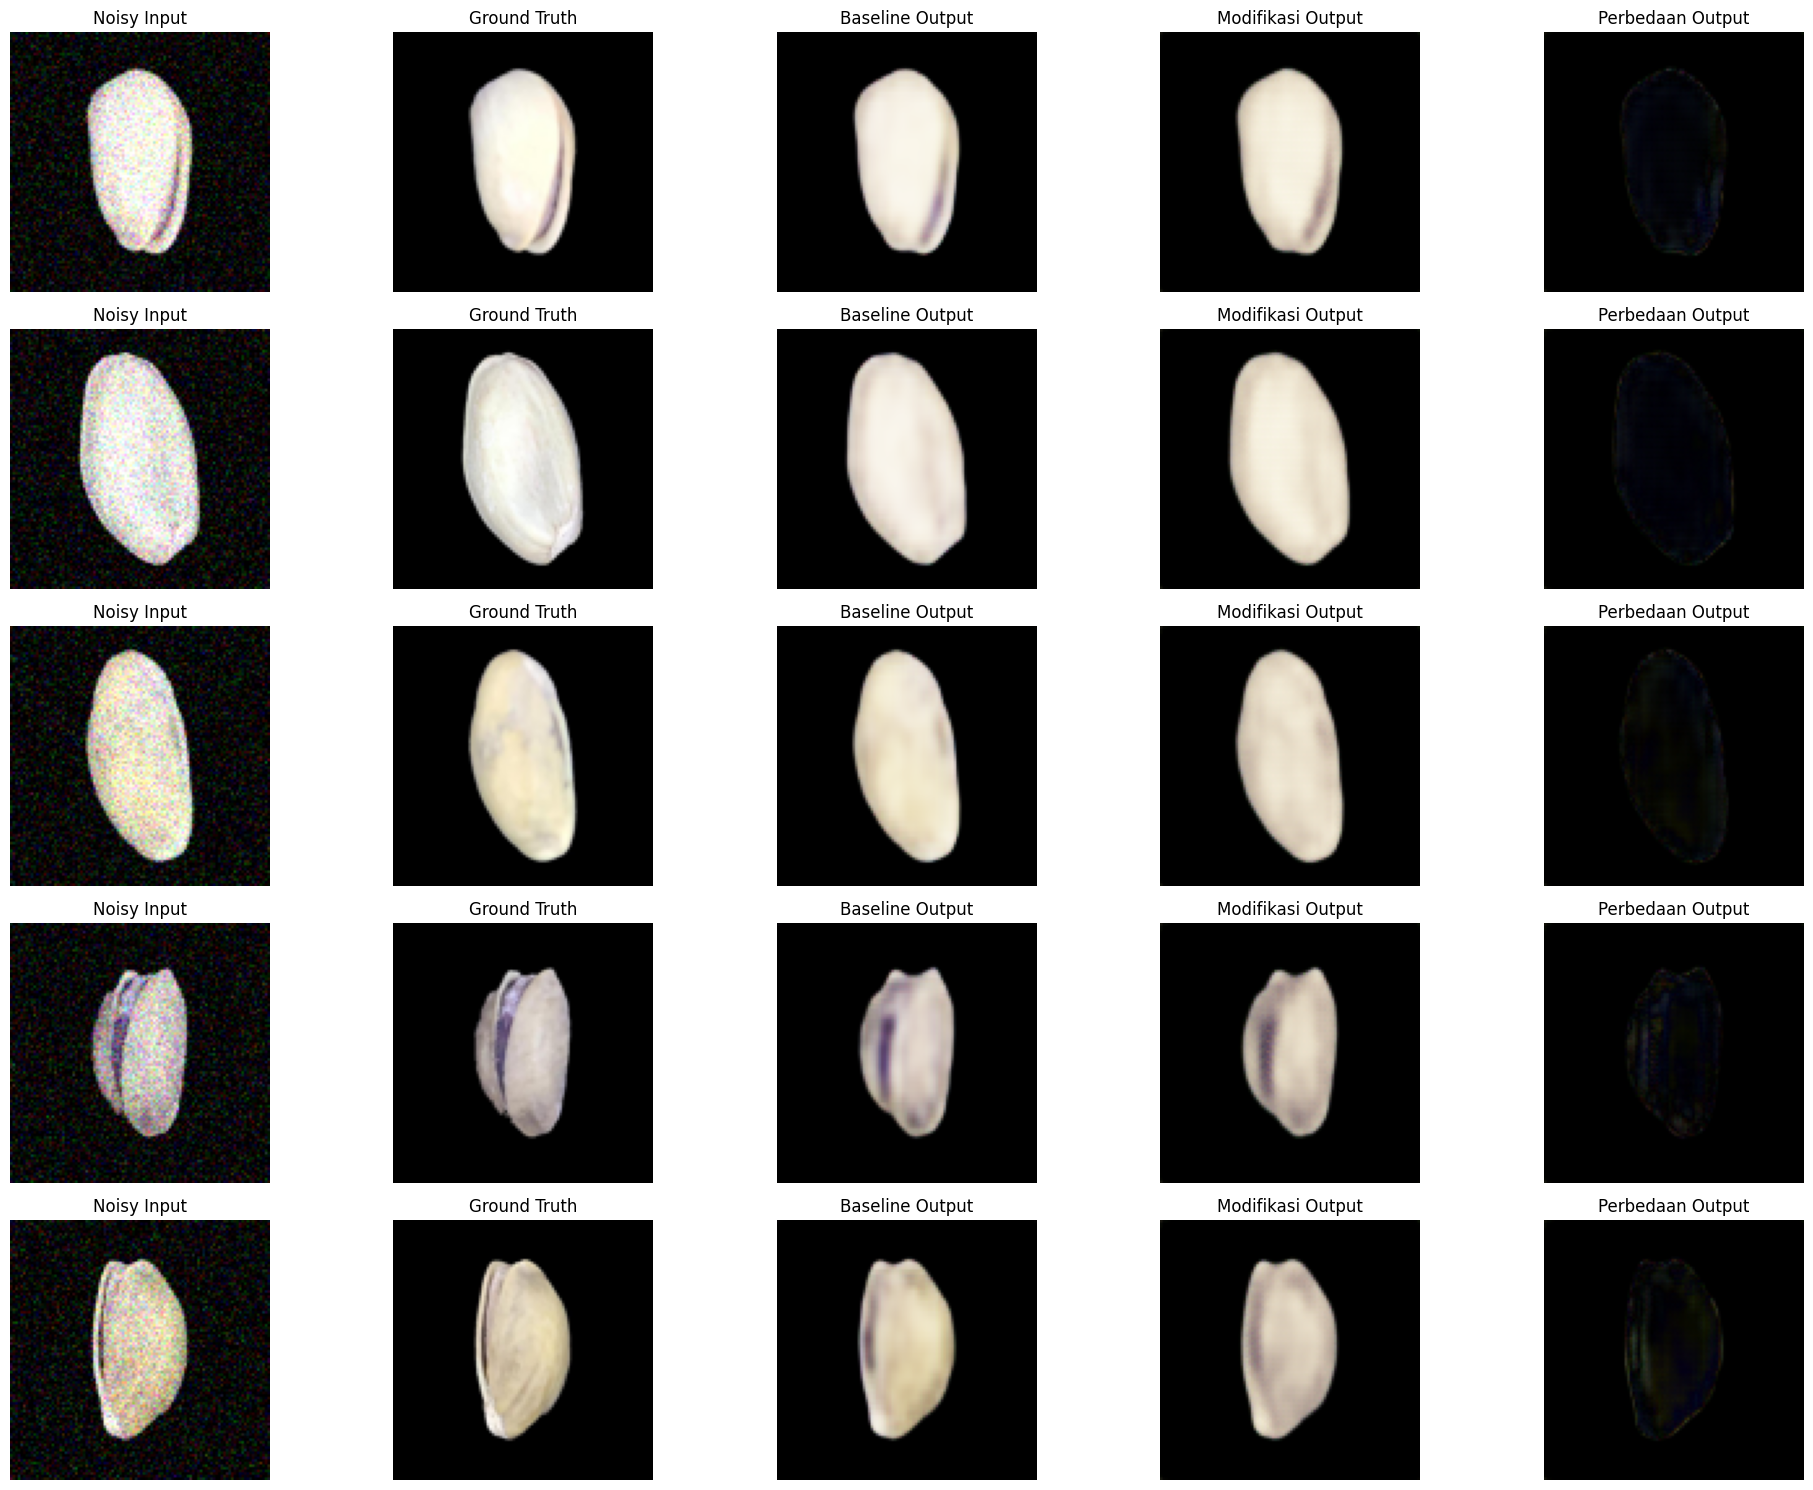

In [26]:
def plot_denoising_comparison(indexes):
    plt.figure(figsize=(20, len(indexes) * 3))
    for i, idx in enumerate(indexes):
        # Baris 1: Input noisy
        plt.subplot(len(indexes), 5, i * 5 + 1)
        plt.imshow(X_test[idx])
        plt.title("Noisy Input")
        plt.axis('off')

        # Baris 2: Ground Truth
        plt.subplot(len(indexes), 5, i * 5 + 2)
        plt.imshow(y_test[idx])
        plt.title("Ground Truth")
        plt.axis('off')

        # Baris 3: Baseline Output
        plt.subplot(len(indexes), 5, i * 5 + 3)
        plt.imshow(y_pred_base[idx])
        plt.title("Baseline Output")
        plt.axis('off')

        # Baris 4: Modifikasi Output
        plt.subplot(len(indexes), 5, i * 5 + 4)
        plt.imshow(y_pred_mod[idx])
        plt.title("Modifikasi Output")
        plt.axis('off')

        # Baris 5: Selisih (Opsional)
        plt.subplot(len(indexes), 5, i * 5 + 5)
        diff = np.abs(y_pred_base[idx] - y_pred_mod[idx])
        plt.imshow(diff)
        plt.title("Perbedaan Output")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Tampilkan sampel ke-0 hingga ke-4
plot_denoising_comparison([0, 1, 2, 3, 4])

Visualisasi perbedaan antara gambar noise, aktual, hasil baseline model, hasil model modif, dan perbedaan antara hasil baseline dan hasil modif